In [7]:
import torch
from torchvision.transforms import v2

import matplotlib.pyplot as plt
from skimage import color, io
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image

In [8]:
model = torch.load('../models/ResNet18_pretrained-epoch8-accuracy0.9829.pt')
model.eval()
device = next(model.parameters()).device.type

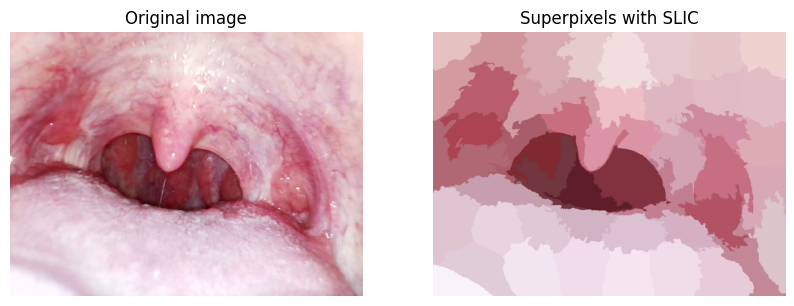

In [9]:
image = io.imread('../data/images/train/equal/4210.jpg')
segments = slic(image, 
                n_segments=50, compactness=15, 
                max_size_factor=2, min_size_factor=0.5
                )

segmented_image = color.label2rgb(segments, image, kind='avg')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(segmented_image)
ax[1].set_title('Superpixels with SLIC')
for a in ax:
    a.axis('off')
plt.show()

In [10]:
preprocess = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def batch_predict(images):
    batch = torch.stack(tuple(preprocess(i) for i in images), dim=0).to(device)
    with torch.no_grad():
        logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(image, batch_predict, 
                                         top_labels=1, hide_color=0, num_samples=1000, 
                                         segmentation_fn=lambda image: slic(image, 
                                                                            n_segments=50, compactness=15, 
                                                                            max_size_factor=2, min_size_factor=0.5
                                                                            )
                                         )

  0%|          | 0/1000 [00:00<?, ?it/s]

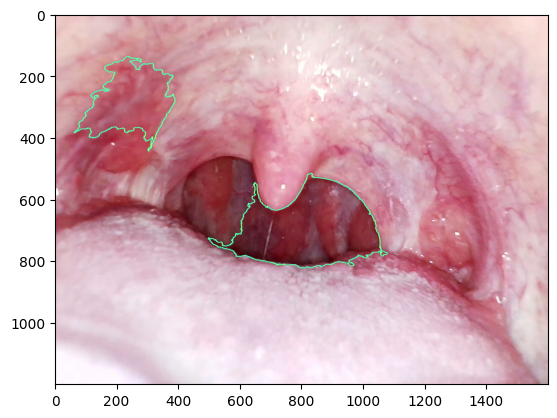

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)

plt.imshow(mark_boundaries(temp/255.0, mask, outline_color=(0, 1, 1)))
plt.show()